In [1]:
! pip install matplotlib numpy opencv-python scikit-image scikit-learn

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

In [4]:
# Generate Masks for All Objects in the Image
def generate_masks(image_path, sam_model):
    # Read image
    image = np.array(Image.open(image_path).convert("RGB"))

    # Initialize mask generator
    mask_generator = SAM2AutomaticMaskGenerator(sam_model)

    # Generate masks
    masks = mask_generator.generate(image)

    return image, masks

In [5]:
# Cut Out All Objects
def cut_out_objects(image, masks):
    object_images = []
    for mask in masks:
        # Extract mask
        mask_array = mask["segmentation"]
        
        # Create cutout for the object
        cutout = image * mask_array[:, :, None]
        object_images.append(cutout)

    return object_images

In [10]:
# Visualize Results
def visualize_results(image, masks, object_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    for i, mask in enumerate(masks):
        # plt.figure(figsize=(5, 5))
        # plt.imshow(mask["segmentation"], cmap="gray")
        # plt.title(f"Mask {i+1}")
        # plt.axis("off")
        # plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(object_images[i])
        plt.title(f"Object {i+1}")
        plt.axis("off")
        plt.show()

In [ ]:
# Path to the input image
image_path = "../inputs/sharks_danger.png"

# Generate masks
image, masks = generate_masks(image_path, sam_model)

# Cut out all objects
object_images = cut_out_objects(image, masks)

# Visualize the results
visualize_results(image, masks, object_images)

In [4]:
def paste_objects_on_blank_canvas(image, masks):
    """
    Cut out each object defined by SAM2 masks and paste onto a blank canvas.
    
    Args:
        image (np.ndarray): Original image in BGR or RGB (H x W x 3).
        masks (list[dict]): List of masks from SAM2 with 'segmentation' and 'bbox' keys.
    
    Returns:
        np.ndarray: Blank canvas with all segmented objects pasted.
    """
    # Prepare a blank canvas of the same dimensions and type as 'image'
    height, width = image.shape[:2]
    blank_canvas = np.zeros((height, width, 3), dtype=np.uint8)
    
    for mask_info in masks:
        # Segmentation mask (boolean array the same size as the image)
        seg = mask_info['segmentation']
        
        # BBox is in XYWH format. Convert to integer if needed.
        x, y, w, h = map(int, mask_info['bbox'])
        x2, y2 = x + w, y + h
        
        # Crop out the object region from the original image
        object_region = image[y:y2, x:x2]
        
        # For convenience, get the corresponding region in the segmentation mask
        seg_region = seg[y:y2, x:x2]
        
        # "Paste" the object onto the blank canvas where the mask is True
        blank_canvas[y:y2, x:x2][seg_region] = object_region[seg_region]
    
    return blank_canvas

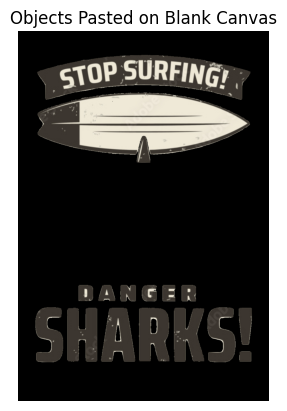

In [5]:
# 1. Load an example image (modify path to your own image)
image_path = "../inputs/sharks_danger.png"
original_image = cv2.imread(image_path)  
# Ensure 'original_image' is loaded. If None, check the file path.

# 2. Generate masks using SAM2
# For illustration, assume 'mask_generator_2' is already defined/configured.
mask_generator = SAM2AutomaticMaskGenerator(sam_model)
# mask_generator_2 = SAM2AutomaticMaskGenerator(
#     model=sam_model,
#     points_per_side=128,  # Increased for finer granularity in object detection.
#     points_per_batch=256,  # Increased to handle more points efficiently.
#     pred_iou_thresh=0.6,  # Slightly lowered to include more objects with less strict IoU.
#     stability_score_thresh=0.88,  # Balanced for both stability and inclusion.
#     stability_score_offset=0.6,  # Slightly reduced for broader stability score acceptance.
#     crop_n_layers=2,  # More cropping layers to capture complex hierarchies.
#     box_nms_thresh=0.6,  # Reduced to allow slightly overlapping detections.
#     crop_n_points_downscale_factor=1,  # No downscaling for precise object segmentation.
#     min_mask_region_area=10.0,  # Reduced to capture smaller objects like text or small graphics.
#     use_m2m=True,  # Enable mask-to-mask refinement for higher-quality results.
# )
# masks = mask_generator_2.generate(original_image)
masks = mask_generator.generate(original_image)

# 3. Paste all detected objects onto a blank canvas
canvas_with_objects = paste_objects_on_blank_canvas(original_image, masks)

# 4. Show the result
# Option A: Use OpenCV (BGR format)
# cv2.imshow("Canvas with Objects", canvas_with_objects)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Option B: Use Matplotlib (assumes RGB format)
# Convert from BGR to RGB for correct color rendering in Matplotlib
canvas_rgb = cv2.cvtColor(canvas_with_objects, cv2.COLOR_BGR2RGB)
plt.imshow(canvas_rgb)
plt.title("Objects Pasted on Blank Canvas")
plt.axis("off")
plt.show()